In [1]:
from bdb2026.data_io import load_bdb_csvs_from_kaggle_download
from bdb2026.preprocess import (add_postthrow_features, merge_route_embeddings, normalize_coordinates, 
                                add_postthrow_features,select_target_receiver_rows,filter_to_completed_catches,
                                attach_output_labels,compute_initial_separation_at_throw, add_converge_rate_from_labels,)
from bdb2026.routes import cluster_routes_kmeans, make_route_embedding_table, engineer_route_features
from bdb2026.sequences import build_sequences
from bdb2026.models import build_lstm, train_lstm
from bdb2026.metrics import compute_truespeed, compute_route_execution_score, build_truespeed_scorecard
from bdb2026.viz import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_input, df_output, df_supp = load_bdb_csvs_from_kaggle_download(
    kaggle_root_dir=r"C:\Users\rajas\Documents\VS_Code\Big_Data_Bowl\114239_nfl_competition_files_published_analytics_final",
    supplementary_csv=r"C:\Users\rajas\Documents\VS_Code\Big_Data_Bowl\114239_nfl_competition_files_published_analytics_final\supplementary_data.csv",
)

In [3]:
df_in = normalize_coordinates(df_input)
sep = compute_initial_separation_at_throw(df_in)

df_wr_target = select_target_receiver_rows(df_in)              
df_wr_target = filter_to_completed_catches(df_wr_target, df_supp)
df_wr_target = df_wr_target.merge(sep, on=["game_id","play_id","nfl_id"], how="left")

df_post = add_postthrow_features(df_wr_target)               # ONLY one argument (your current API)
df_post = attach_output_labels(df_post, df_output) 
df_post = add_converge_rate_from_labels(df_post) 

In [4]:
# Build route features on the pre-throw window (targeted receiver), then cluster
df_routes = engineer_route_features(df_wr_target, df_raw_tracking=df_in)
#df_routes = df_routes[df_routes["route_frames"] >= 5].copy() # only cluster on routes with at least 5 frames
route_result = cluster_routes_kmeans(df_routes, n_clusters=12)
route_emb = make_route_embedding_table(route_result.assignments, n_clusters=12, prefix='route_emb')

# merge the static embedding columns
df_features = merge_route_embeddings(df_post, route_emb)

# # CRITICAL: Broadcast sep_at_catch from play-level to frame-level
# # Extract sep_at_catch from route features (one value per play/player)
# sep_at_catch_df = df_routes[['game_id', 'play_id', 'nfl_id', 'sep_at_catch']].copy()

# # Merge onto frame-level data so LSTM sees it at every timestep
# df_features = df_features.merge(
#     sep_at_catch_df, 
#     on=['game_id', 'play_id', 'nfl_id'], 
#     how='left'
# )

# # Fill any missing values with 10.0 (wide open)
# df_features['sep_at_catch'] = df_features['sep_at_catch'].fillna(10.0)

In [5]:
# Include route_emb_* columns in feature_cols when building LSTM tensors
feature_cols = [
    # Position
    'x_norm', 'y_norm',
    # Motion
    'dx', 'dy', 'speed',
    # Geometry
    'dist_to_land', 'bearing_to_land', 'heading', 'heading_align_cos',
    # Temporal
    'time_since_throw',
    # Context (constant per play)
    'initial_separation', 'ball_land_x_norm', 'ball_land_y_norm',
    #'sep_at_catch'  # NEW: Separation from nearest defender at catch point
    
]  + [c for c in df_features.columns if c.startswith('route_emb_')]
print(f"Route embeddings: {len([c for c in df_features.columns if c.startswith('route_emb_')])}")
print(f"Total features: {len(feature_cols)}")

X, y, keys = build_sequences(
    df_features,
    feature_cols=feature_cols,
    target_col="converge_rate",
    max_len=25
)

Route embeddings: 12
Total features: 25


In [6]:
model = build_lstm(n_features=X.shape[-1], hidden_units=64, dropout=0.2, mask_value=0.0)
result = train_lstm(model, X, y, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 27.3941 - mae: 4.3515 - learning_rate: 0.0010
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 26.7870 - mae: 4.3017 - learning_rate: 0.0010
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 26.0645 - mae: 4.2529 - learning_rate: 0.0010
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 25.5076 - mae: 4.2057 - learning_rate: 0.0010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 24.8826 - mae: 4.1596 - learning_rate: 0.0010
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 24.2497 - mae: 4.1148 - learning_rate: 0.0010
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 23.6740 - mae: 4.0713 - learning_rate: 0.0010
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 23.1471 - mae: 4.0289 - learning_rate: 0.0010
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 22.6141 - mae: 3.9877 - learning_rate: 0.0010
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - l

In [7]:
# Display model architecture
print("=" * 60)
print("MODEL ARCHITECTURE SUMMARY")
print("=" * 60)
result.model.summary()

# Save the trained model
import os
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, "truespeed_lstm_without_sep_at_catch.h5")
#result.model.save(model_path)
print(f"\n✓ Model saved to: {model_path}")

# Also save model configuration for reference
print(f"\nModel Configuration:")
print(f"  - Input features: {X.shape[-1]}")
print(f"  - Sequence length: {X.shape[1]}")
print(f"  - Training samples: {X.shape[0]}")
print(f"  - Hidden units: 64")
print(f"  - Dropout: 0.2")
print(f"  - Epochs: 50")
print(f"  - Batch size: 64")

MODEL ARCHITECTURE SUMMARY


Model: "convergence_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, None, 25)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 64)       │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 32)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (TimeDistributed)       │ (None, None, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (TimeDistributed)        │ (None, None, 1)        │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,005 (421.90 KB)

 Trainable params: 36,001 (140.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 72,004 (281.27 KB)


✓ Model saved to: models\truespeed_lstm_without_sep_at_catch.h5

Model Configuration:
  - Input features: 25
  - Sequence length: 25
  - Training samples: 5547
  - Hidden units: 64
  - Dropout: 0.2
  - Epochs: 50
  - Batch size: 64


In [8]:
# Predict + compute TrueSpeed per play
y_hat = result.model.predict(X)
df_pred = (
    pd.DataFrame(keys, columns=["game_id","play_id"])
      .assign(idx=np.arange(len(keys)))
      .merge(
          pd.DataFrame({
              "idx": np.repeat(np.arange(len(keys)), X.shape[1]),
              "t": np.tile(np.arange(X.shape[1]), len(keys)),
              "actual": y.reshape(-1),
              "pred": y_hat.reshape(-1),
          }),
          on="idx",
      )
)
df_pred['residual'] = df_pred['actual'] - df_pred['pred']
ts = compute_truespeed(df_pred, actual_col="actual", pred_col="pred", id_cols=("game_id","play_id"), agg="mean")
ts.head()

174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


,game_id,play_id,TrueSpeed
0,2023090700,361,-1.295658
1,2023090700,436,-2.464514
2,2023090700,461,-1.315064
3,2023090700,530,-3.244559
4,2023090700,621,-1.523692


In [9]:
df_pred.head()

,game_id,play_id,idx,t,actual,pred,residual
0,2023090700,361,0,0,0.000000,3.286551,-3.286551
1,2023090700,361,0,1,0.321365,3.286551,-2.965185
2,2023090700,361,0,2,0.799144,3.286551,-2.487407
3,2023090700,361,0,3,1.364456,3.286551,-1.922094
4,2023090700,361,0,4,1.914580,3.286551,-1.371971


In [10]:
# Use the actual column names from engineer_route_features() output
# These correspond to the 7 key features used in the notebook
route_feature_cols = [
    'route_len',         # corresponds to route_embed_1 (route_distance)
    'delta_x',           # corresponds to route_embed_2 (route_depth)  
    'delta_y_abs',       # corresponds to route_embed_3 (route_width - NOW ABSOLUTE!)
    'max_speed',         # corresponds to route_embed_6 (max_speed)
    'mean_speed',        # corresponds to route_embed_7 (avg_speed)
    'direction_changes', # corresponds to route_embed_11 (direction_changes)
    'straightness',       # corresponds to route_embed_15 (route_efficiency)
    #'sep_at_catch'      # new feature added for separation at catch
]

# 1) play-level TrueSpeed from residuals
truespeed_play = compute_truespeed(
    df_pred,
    actual_col="actual",
    pred_col="pred",   # set to your model output col
    id_cols=("game_id", "play_id"),
    agg="mean",
    out_col="TrueSpeed",
)

# 2) play-level RouteExecution score (requires route clustering artifacts)
route_exec_play = compute_route_execution_score(
    route_features=df_routes,                 # output of engineer_route_features(...)
    assignments=route_result.assignments,     # from cluster_routes_kmeans(...)
    centroids=route_result.centroids,         # from cluster_routes_kmeans(...)
    feature_cols=route_feature_cols,
    id_cols=("game_id", "play_id"),
)
print(route_exec_play.columns)

# 3) player-level table matching your CSV

df_scorecard = build_truespeed_scorecard(
    truespeed_play=truespeed_play,
    route_exec_play=route_exec_play,
    df_input=df_input,
    df_supp=df_supp,
    volume_threshold_ratio=0.50,
    junk_routes=("SCREEN","FLAT","ANGLE","WHEEL","SHIELD"),
)

#df_scorecard.to_csv("TrueSpeed_without_separation.csv", index=False)

Index(['game_id', 'play_id', 'RouteExecution'], dtype='object')


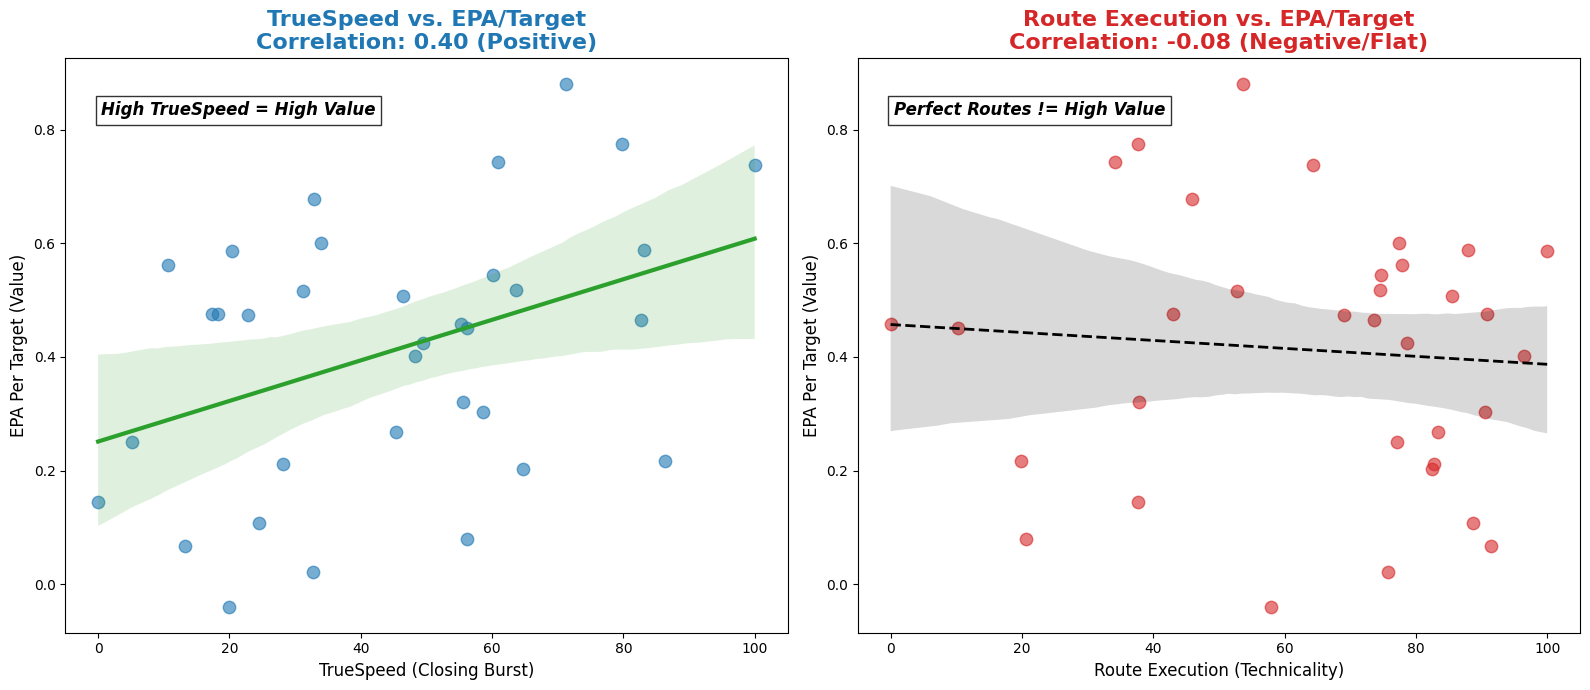

In [11]:
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import seaborn as sns
df= df_scorecard.copy()
# Clean Data
cols_to_numeric = ['TrueSpeed', 'RouteExecution', 'EPA_Per_Target']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_clean = df.dropna(subset=cols_to_numeric)

# Setup Figure
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot 1: TrueSpeed vs EPA ---
sns.regplot(
    x='TrueSpeed', 
    y='EPA_Per_Target', 
    data=df_clean, 
    ax=axes[0], 
    color='#1f77b4', # Blue
    scatter_kws={'alpha':0.6, 's':80},
    line_kws={'color': '#2ca02c', 'linewidth': 3}
)

corr_ts, _ = pearsonr(df_clean['TrueSpeed'], df_clean['EPA_Per_Target'])

axes[0].set_title(f"TrueSpeed vs. EPA/Target\nCorrelation: {corr_ts:.2f} (Positive)", fontsize=16, weight='bold', color='#1f77b4')
axes[0].set_xlabel("TrueSpeed (Closing Burst)", fontsize=12)
axes[0].set_ylabel("EPA Per Target (Value)", fontsize=12)
#axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].text(0.05, 0.9, "High TrueSpeed = High Value", transform=axes[0].transAxes, fontsize=12, style='italic', weight='bold', bbox=dict(facecolor='white', alpha=0.8))


# --- Plot 2: Route Execution vs EPA ---
sns.regplot(
    x='RouteExecution', 
    y='EPA_Per_Target', 
    data=df_clean, 
    ax=axes[1], 
    color='#d62728', # Red for 'Warning'
    scatter_kws={'alpha':0.6, 's':80},
    line_kws={'color': 'black', 'linewidth': 2, 'linestyle': '--'}
)

corr_re, _ = pearsonr(df_clean['RouteExecution'], df_clean['EPA_Per_Target'])

axes[1].set_title(f"Route Execution vs. EPA/Target\nCorrelation: {corr_re:.2f} (Negative/Flat)", fontsize=16, weight='bold', color='#d62728')
axes[1].set_xlabel("Route Execution (Technicality)", fontsize=12)
axes[1].set_ylabel("EPA Per Target (Value)", fontsize=12)
#axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].text(0.05, 0.9, "Perfect Routes != High Value", transform=axes[1].transAxes, fontsize=12, style='italic', weight='bold', bbox=dict(facecolor='white', alpha=0.8))

# Main Title
#plt.suptitle("The Market Inefficiency: Athleticism Trumps Technique", fontsize=20, weight='bold', y=1.05)

plt.tight_layout()
plt.savefig("market_inefficiency_correlations.png")
plt.show()

In [12]:
from bdb2026.metrics import build_truespeed_scouting_scorecard
scorecard_ts = build_truespeed_scouting_scorecard(truespeed_play=truespeed_play, df_input=df_input, df_supp=df_supp)
scorecard_ts

,Rank,player_name,TrueSpeed,TrueSpeed_raw,Scored_Count,Total_Targets,Total_Yards,Total_EPA,Catch_Rate,Explosive_Plays,Success_Rate,Yards_Per_Target,EPA_Per_Target
0,23.0,A.J. Brown,31.2,-1.552968,100,137,1416,70.792940,0.729927,20,0.583942,10.335766,0.516737
1,29.0,Adam Thielen,18.3,-1.724140,83,114,910,54.168963,0.728070,9,0.605263,7.982456,0.475166
2,4.0,Amari Cooper,82.7,-0.871604,71,112,1231,51.982011,0.633929,21,0.571429,10.991071,0.464125
3,26.0,Amon-Ra St. Brown,22.8,-1.665297,97,134,1382,63.481378,0.723881,23,0.634328,10.313433,0.473742
4,5.0,Brandon Aiyuk,79.8,-0.909892,73,98,1350,75.838372,0.744898,29,0.714286,13.775510,0.773861
5,14.0,Calvin Ridley,55.5,-1.231810,65,112,932,35.967090,0.580357,16,0.553571,8.321429,0.321135
6,21.0,CeeDee Lamb,32.9,-1.531418,118,157,1672,106.349919,0.751592,31,0.630573,10.649682,0.677388
7,27.0,Chris Godwin Jr.,20.4,-1.696840,72,104,975,60.969608,0.692308,14,0.586538,9.375000,0.586246
8,19.0,Chris Olave,45.3,-1.367081,71,115,985,30.795716,0.617391,15,0.556522,8.565217,0.267789
9,2.0,Courtland Sutton,86.3,-0.823106,54,80,709,17.346502,0.675000,14,0.525000,8.862500,0.216831


# Front Page Visuals + Context Splits + Exemplars

This section renders the “front page” plots, builds a play-level context frame (`df_play`) for splits/film exemplars, and provides an “aha” view (actual vs expected converge_rate + on-field animation) for a selected play.

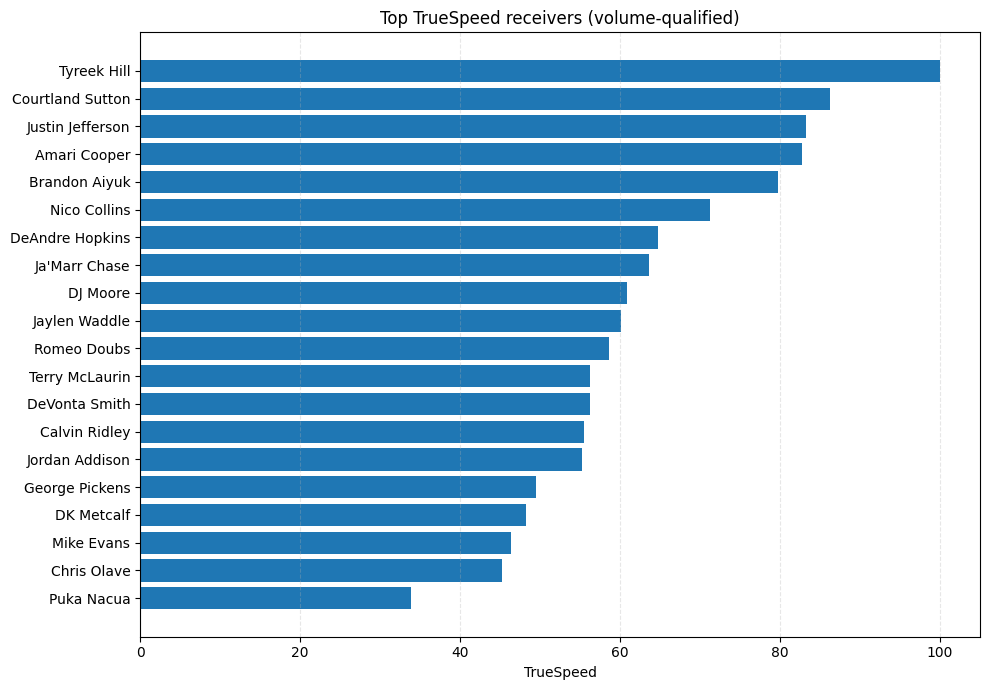

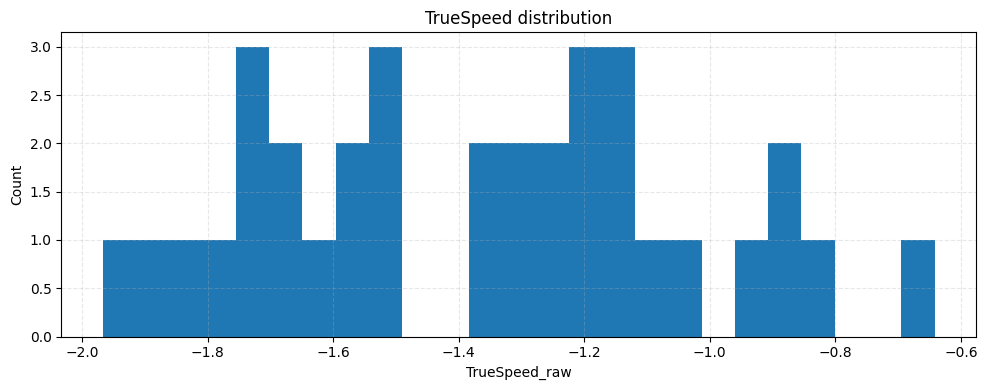

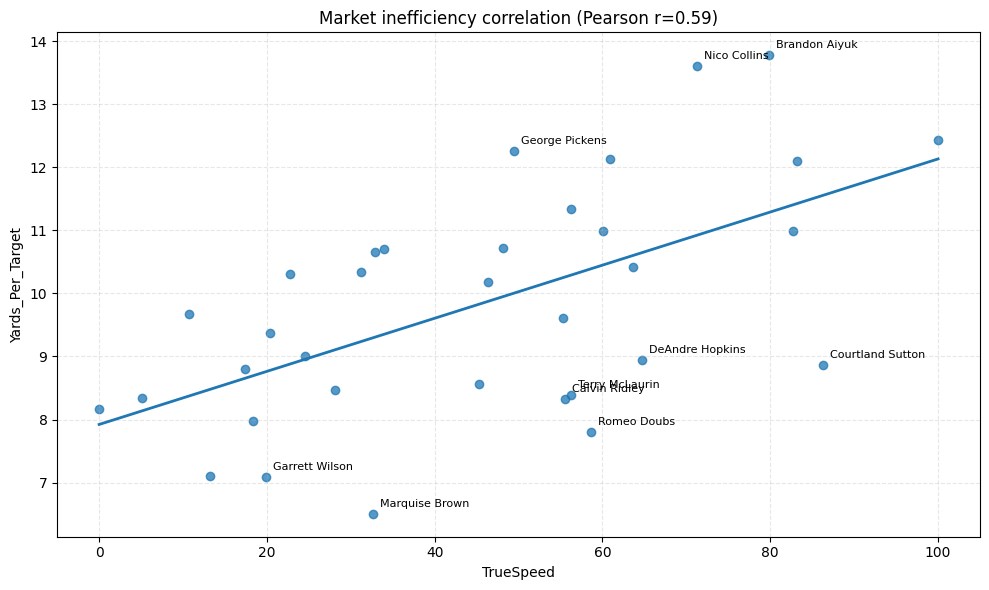

In [17]:
import matplotlib.pyplot as plt

# 1) Leaderboard
fig = plot_truespeed_leaderboard(df_scorecard, top_n=20, min_targets=15)
plt.show()

# 2) Distribution
fig = plot_truespeed_distribution(df_scorecard)
plt.show()

# 3) Correlation (Market inefficiency)
fig = plot_market_inefficiency_correlation(df_scorecard, x_col="TrueSpeed", y_col="Yards_Per_Target")
plt.show()

In [14]:
# Build a play-level context frame for splits + exemplars

# Targeted receiver mapping (one row per play)
name_candidates = ["player_name", "displayName", "player_display_name", "name"]
name_col = next((c for c in name_candidates if c in df_wr_target.columns), None)

base_cols = ["game_id", "play_id", "nfl_id", "frame_id"]
cols = [c for c in base_cols if c in df_wr_target.columns]
if name_col:
    cols.append(name_col)

_df_target = (
    df_wr_target.loc[:, cols]
    .sort_values([c for c in ["game_id", "play_id", "frame_id"] if c in cols])
    .groupby(["game_id", "play_id"], as_index=False)
    .first()
)

keep = ["game_id", "play_id", "nfl_id"] + ([name_col] if name_col else [])
df_target = _df_target.loc[:, keep].copy()

if name_col and name_col != "player_name":
    df_target = df_target.rename(columns={name_col: "player_name"})
if "player_name" not in df_target.columns:
    df_target["player_name"] = df_target["nfl_id"].astype(str)

# Merge: play context (df_supp) + targeted receiver + play-level TrueSpeed
# truespeed_play is play-level by (game_id, play_id) in this pipeline

df_play = df_supp.merge(df_target, on=["game_id", "play_id"], how="left")
df_play = df_play.merge(truespeed_play, on=["game_id", "play_id"], how="left")

# Optional: attach RouteExecution if present
if "RouteExecution" in route_exec_play.columns:
    df_play = df_play.merge(route_exec_play[["game_id", "play_id", "RouteExecution"]], on=["game_id", "play_id"], how="left")

print("df_play shape:", df_play.shape)
df_play.head()

df_play shape: (18009, 45)


,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,play_id,play_description,quarter,...,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added,nfl_id,player_name,TrueSpeed,RouteExecution
0,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,3461,(10:46) (Shotgun) J.Goff pass deep left to J.R...,4,...,-0.664416,2.945847,0.834296,0.165704,-0.081149,0.081149,44930.0,Josh Reynolds,-1.558656,95.3
1,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,461,(7:30) J.Goff pass short right to J.Reynolds t...,1,...,1.926131,1.345633,0.544618,0.455382,-0.029415,0.029415,44930.0,Josh Reynolds,-1.315064,94.9
2,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1940,(:09) (Shotgun) J.Goff pass incomplete deep ri...,2,...,0.281891,-0.081964,0.771994,0.228006,0.000791,-0.000791,NaN,NaN,NaN,NaN
3,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1711,"(:45) (No Huddle, Shotgun) P.Mahomes pass deep...",2,...,3.452352,2.342947,0.663187,0.336813,0.041843,-0.041843,46213.0,Justin Watson,0.418805,97.9
4,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1588,(1:54) (Shotgun) P.Mahomes pass incomplete dee...,2,...,1.921525,-0.324035,0.615035,0.384965,0.000061,-0.000061,NaN,NaN,NaN,NaN


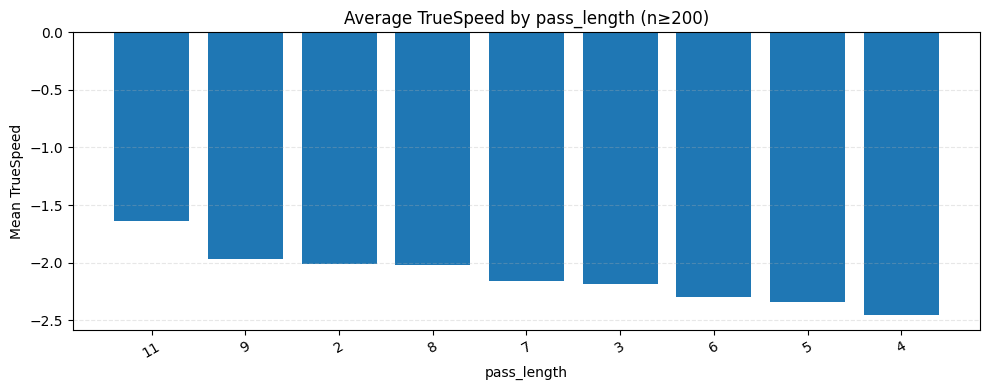

Using player_for_film: Tyreek Hill


,game_id,play_id,player_name,TrueSpeed
0,2023120306,1480,Tyreek Hill,6.013957
1,2023102904,838,Tyreek Hill,6.483445
2,2023091010,4426,Tyreek Hill,6.773538
3,2023102210,775,Tyreek Hill,-1.052579
4,2023111906,2390,Tyreek Hill,-1.030747
5,2023092405,838,Tyreek Hill,-1.023346
6,2024010713,3906,Tyreek Hill,-3.780534
7,2023091712,2685,Tyreek Hill,-3.681060
8,2024010713,133,Tyreek Hill,-3.632396


In [15]:
# Context splits (examples)

# This will raise if df_play doesn't have the column.
# Common df_supp columns include: pass_length, coverage, etc.
for split_col in ["pass_length"]:
    if split_col in df_play.columns:
        fig = plot_truespeed_context_splits(df_play, split_col=split_col, min_n=200)
        plt.show()
    else:
        print(f"df_play missing split_col={split_col!r}; available columns include: {sorted(df_play.columns)[:20]} ...")

# Exemplars for film review
player_for_film = None
if "player_name" in df_scorecard.columns and len(df_scorecard) > 0:
    player_for_film = df_scorecard.sort_values("TrueSpeed", ascending=False)["player_name"].iloc[0]

print("Using player_for_film:", player_for_film)
exemplars = select_exemplar_plays_for_film(df_play, player_name=player_for_film, n_each=3)
exemplars

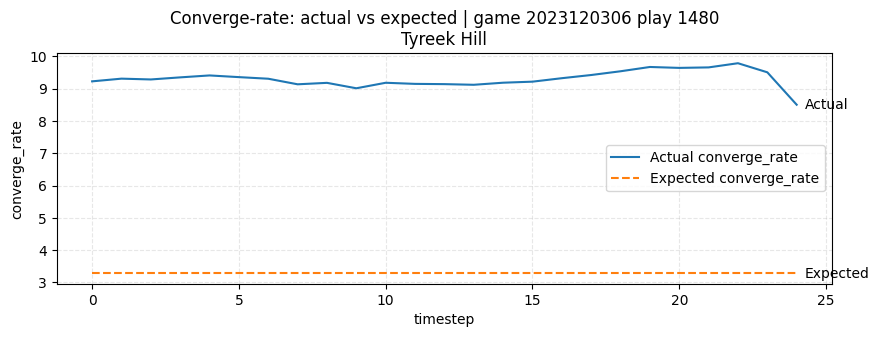

In [16]:
# “Aha” view for a chosen play: actual vs expected converge_rate + on-field animation

import numpy as np
import importlib
import bdb2026.viz as viz
from IPython.display import HTML, display

if exemplars is None or len(exemplars) == 0:
    raise ValueError("No exemplars returned; pick a player_name that exists in df_play.")

row0 = exemplars.iloc[0]
game_id = int(row0["game_id"])
play_id = int(row0["play_id"])
player_name = str(row0.get("player_name", ""))
target_nfl_id = int(row0["nfl_id"]) if "nfl_id" in row0 and pd.notna(row0["nfl_id"]) else None

# 1) Time-series: actual vs expected converge_rate (model output)
play_pred = df_pred[(df_pred["game_id"] == game_id) & (df_pred["play_id"] == play_id)].copy()
play_pred = play_pred.sort_values("t")

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(play_pred["t"], play_pred["actual"], label="Actual converge_rate")
ax.plot(play_pred["t"], play_pred["pred"], label="Expected converge_rate", linestyle="--")

# Label the lines at the last timestep
t_last = int(play_pred["t"].iloc[-1])
y_last_actual = float(play_pred["actual"].iloc[-1])
y_last_expected = float(play_pred["pred"].iloc[-1])
ax.annotate("Actual", xy=(t_last, y_last_actual), xytext=(6, 0), textcoords="offset points", va="center")
ax.annotate("Expected", xy=(t_last, y_last_expected), xytext=(6, 0), textcoords="offset points", va="center")

ax.set_title(f"Converge-rate: actual vs expected | game {game_id} play {play_id}\n{player_name}")
ax.set_xlabel("timestep")
ax.set_ylabel("converge_rate")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(loc="best")
plt.show()

# 2) On-field animation (tracking)
# Show only Defense + QB + Tyreek, and annotate Actual/Pred/Residual on the field.
importlib.reload(viz)

fig_anim = viz.animate_speed_comparison(
    df_input=df_input,
    df_output=df_output,
    game_id=game_id,
    play_id=play_id,
    player_name=player_name,
    target_nfl_id=target_nfl_id,
    truespeed_score=float(row0.get("TrueSpeed", np.nan)) if "TrueSpeed" in row0 else None,
    x_col="x",
    y_col="y",
    frame_col="frame_id",
    show_only_defense_qb_target=True,
    pred_df=play_pred[["t", "actual", "pred"]].reset_index(drop=True),
    pred_actual_col="actual",
    pred_pred_col="pred",
    annotation_xy=(6.0, 52.0),
 )

# Render explicitly as HTML to avoid nbformat/mimetype renderer issues in some VS Code setups.
display(HTML(fig_anim.to_html(include_plotlyjs="cdn")))